In [1]:
import pickle


device = "cuda:0"

with open("data/train.pkl", "rb") as file:
    train_dataset = pickle.load(file)

with open("data/test_no_target.pkl", "rb") as file:
    test_dataset = pickle.load(file)

In [2]:
import torch
print(torch.cuda.is_available())
device="cuda"

True


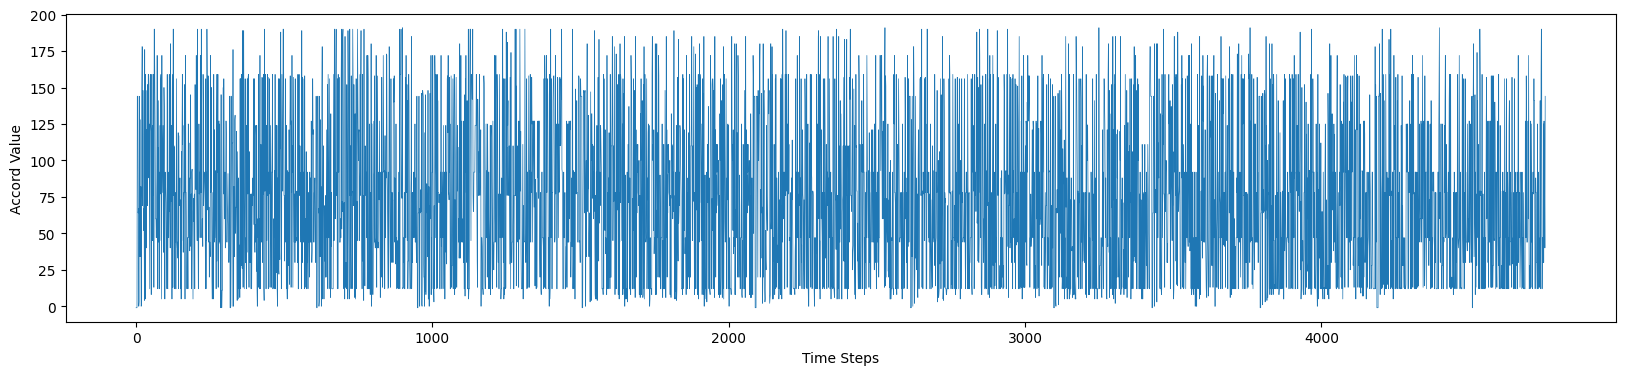

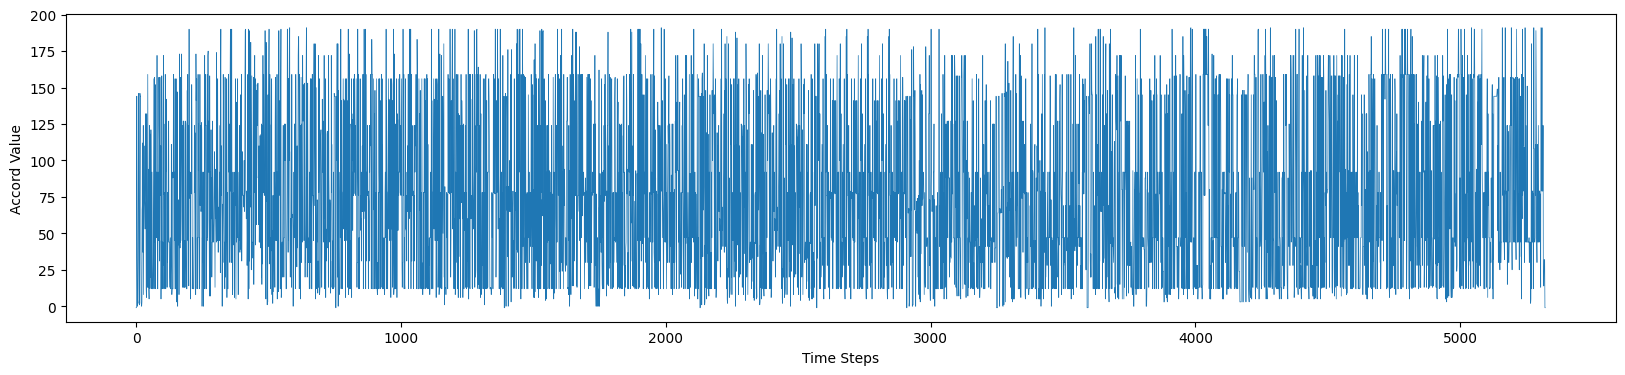

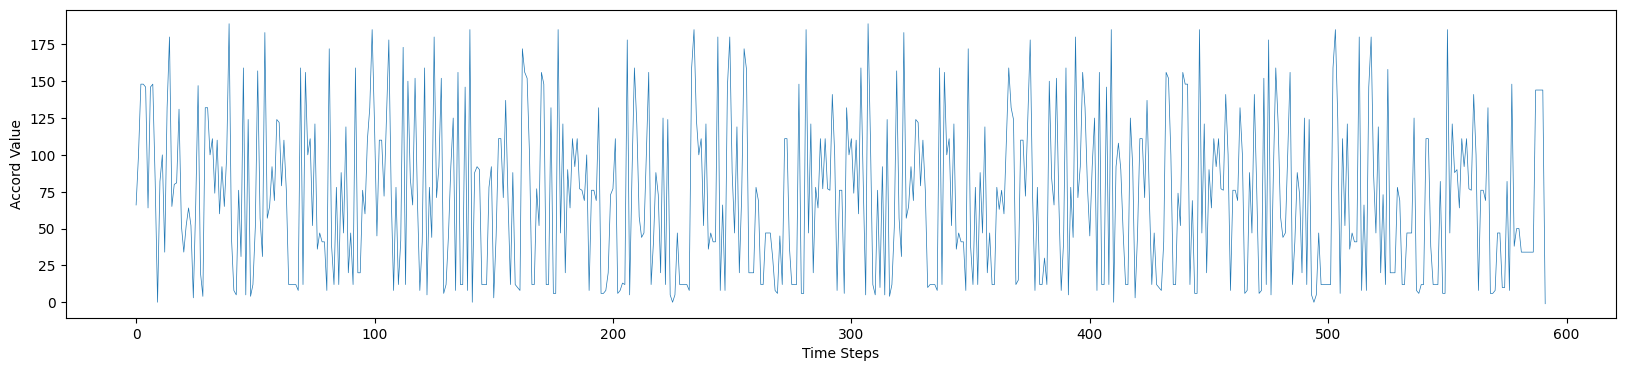

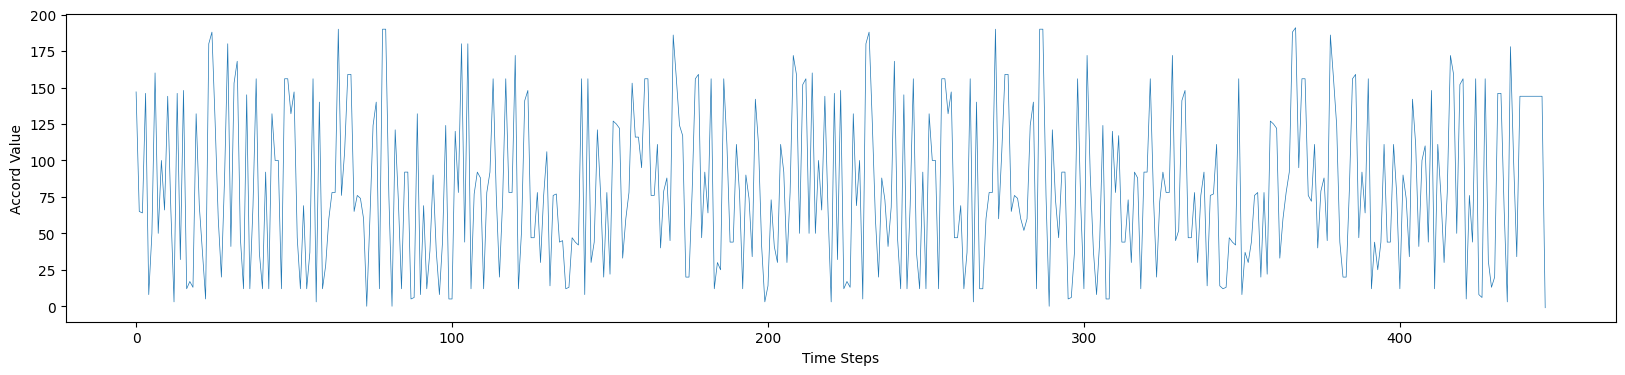

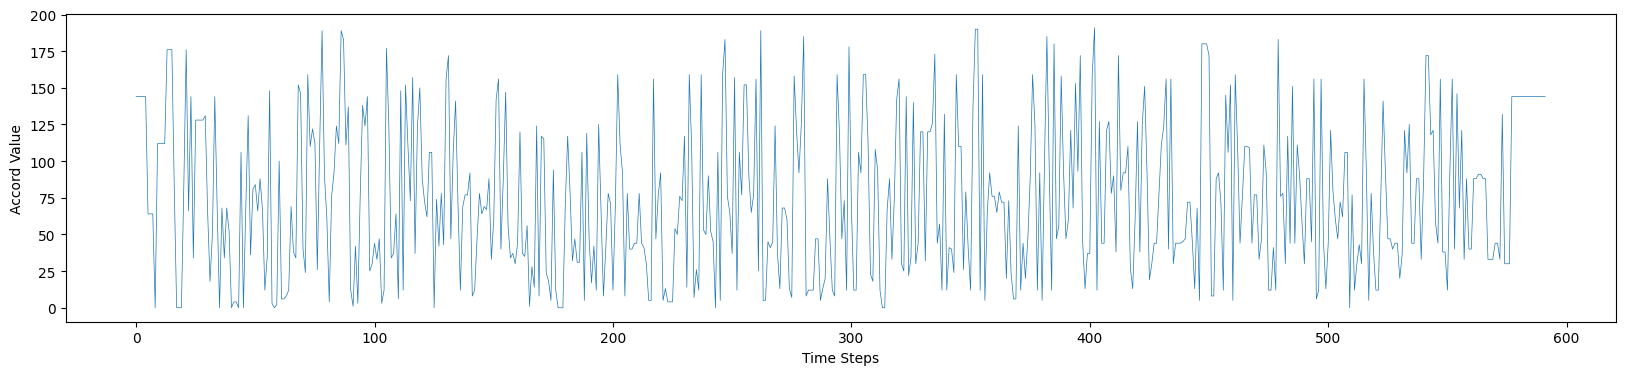

In [ ]:
import matplotlib.pyplot as plt


training_examples = train_dataset[:5]
for sequence, _ in training_examples:
    plt.figure(figsize=(20, 4)) 
    plt.plot(sequence, linewidth=0.5)
    plt.xlabel("Time Steps")
    plt.ylabel("Accord Value")
    plt.show()
    plt.close()

[('bach', 1630), ('beethoven', 478), ('debussy', 154), ('scarlatti', 441), ('victoria', 236)]


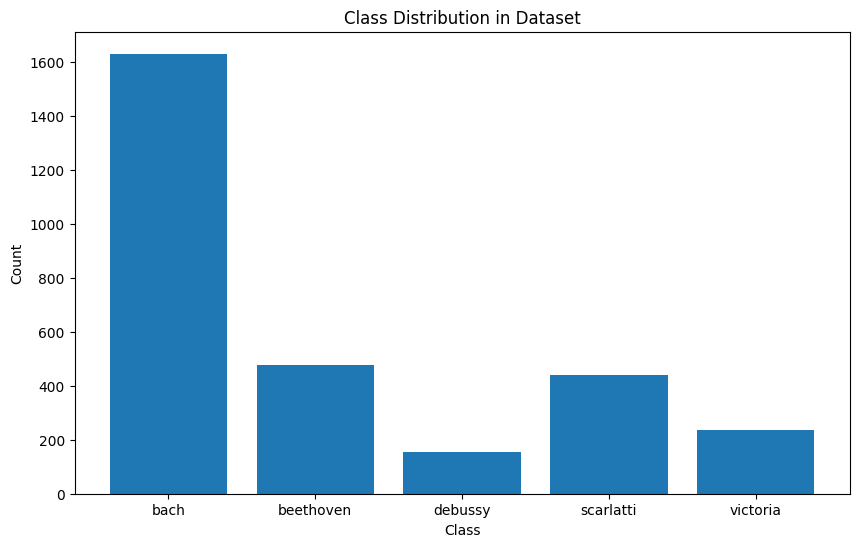

In [19]:
from collections import Counter


labels = [label for _, label in train_dataset]
class_counts = Counter(labels)
class_names = {0: 'bach', 1: 'beethoven', 2: 'debussy', 3: 'scarlatti', 4: 'victoria'}
class_labels = [class_names[key] for key in class_counts.keys()]
class_values = list(class_counts.values())

print(list(zip(class_labels, class_values)))

plt.figure(figsize=(10, 6))
plt.bar(class_labels, class_values)
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Distribution in Dataset")
plt.show()

In [5]:
import torch
from torch.utils.data import Dataset


class VariableLenDataset(Dataset):
    def __init__(self, in_data, target):
        self.data = [(x, y) for x, y in zip(in_data, target)]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        in_data, target = self.data[idx]
        return torch.tensor(in_data, dtype=torch.float32), torch.tensor(target)
    
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32)

In [6]:
from sklearn.model_selection import train_test_split


train_data, val_data = train_test_split(train_dataset, test_size=0.2, random_state=42, stratify=labels)
train_sequences, train_labels = zip(*train_data)
val_sequences, val_labels = zip(*val_data)
train_set = VariableLenDataset(train_sequences, train_labels)
val_set = VariableLenDataset(val_sequences, val_labels)
test_set = TestDataset(test_dataset)

In [8]:
from torch.nn.utils.rnn import pad_sequence


def pad_collate(batch, pad_value=0):
    xx, yy = zip(*batch)
    x_lens = [len(x) for x in xx]

    xx_pad = pad_sequence(xx, batch_first=True, padding_value=pad_value)

    yy = torch.tensor(yy)
    return xx_pad, yy, x_lens

def test_pad_collate(batch, pad_value=0):
    x_lens = [len(x) for x in batch]
    xx_pad = pad_sequence(batch, batch_first=True, padding_value=pad_value)
    return xx_pad, x_lens

In [189]:
# from torch.utils.data import WeightedRandomSampler

# _, labels = zip(*train_data)
# class_counts_in_train_set = Counter(labels)
# num_classes = len(class_names)

# class_sample_counts = [class_counts_in_train_set.get(i, 0) for i in range(num_classes)]
# class_weights = [1.0 / count if count > 0 else 0 for count in class_sample_counts]
# sample_weights = [class_weights[label_idx] for label_idx in labels]

# sample_weights_tensor = torch.DoubleTensor(sample_weights)
# train_sampler = WeightedRandomSampler(
#     weights=sample_weights_tensor,
#     num_samples=len(sample_weights_tensor),
#     replacement=True
# )

In [193]:
class Config():
	batch_size=32
	hidden_size=128
	dropout=0.25
	lstm_dropout=0.0
	alpha=0.5
	num_epochs=130
	lr=5e-4
	weight_decay=1e-5
	eta_min=1e-6

In [194]:
from torch.utils.data import DataLoader


train_loader = DataLoader(
    train_set, batch_size=Config.batch_size, shuffle=True, collate_fn=pad_collate
)
val_loader = DataLoader(
    val_set, batch_size=Config.batch_size, shuffle=False, drop_last=False, collate_fn=pad_collate
)
test_loader = DataLoader(
    test_set, batch_size=Config.batch_size, shuffle=False, drop_last=False, collate_fn=test_pad_collate
)

In [195]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence


class LSTMClassifier(nn.Module):
    def __init__(
        self, input_size, hidden_size, num_layers, out_size, bidirectional=False, dropout=0.2, lstm_droput=0.0
    ):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        if bidirectional:
            self.bidirectional = 2
        else:
            self.bidirectional = 1
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            bidirectional=bidirectional,
            batch_first=True,
            dropout=lstm_droput
        )
        self.dropout_layer = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size * self.bidirectional, out_size)

    def init_hidden(self, batch_size):
        hidden = torch.zeros(
            self.num_layers * self.bidirectional, batch_size, self.hidden_size
        )
        state = torch.zeros(
            self.num_layers * self.bidirectional, batch_size, self.hidden_size
        )
        return hidden, state

    def forward(self, x, hidden, x_len):
        x = pack_padded_sequence(x, x_len, batch_first=True, enforce_sorted=False) # batch_first=True powoduje [batch, seq, feature] -> [seq, batch, feature]
        all_outputs, hidden = self.lstm(x, hidden)
        all_outputs, _ = pad_packed_sequence(all_outputs, batch_first=True, padding_value=0)
        batch_size = all_outputs.size(0)
        last_outputs_idx = (torch.tensor(x_len) - 1).to(device) # -1 because of zero indexing
        last_outputs = all_outputs[torch.arange(batch_size), last_outputs_idx, :]
        dropped_outputs = self.dropout_layer(last_outputs)
        x = self.fc(dropped_outputs)
        return x, hidden


model = LSTMClassifier(1, 128, 2, 5, True, Config.dropout, Config.lstm_dropout).to(device)
model

LSTMClassifier(
  (lstm): LSTM(1, 128, num_layers=2, batch_first=True, bidirectional=True)
  (dropout_layer): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=256, out_features=5, bias=True)
)

In [196]:
import numpy as np


counts = [class_counts.get(i, 0) for i in range(len(class_names))]

alpha = Config.alpha
weights = 1.0/(np.array(counts)**alpha)
weights = weights / weights.mean()
weights = torch.tensor(weights, dtype=torch.float32).to(device)

In [197]:
from sklearn.metrics import balanced_accuracy_score
from torch.optim.lr_scheduler import CosineAnnealingLR

num_epochs = Config.num_epochs
optimizer = torch.optim.Adam(model.parameters(), lr=Config.lr, weight_decay=Config.weight_decay)
loss_fun = nn.CrossEntropyLoss(weight=weights)
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=Config.eta_min)

In [198]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    num_train_batches = 0

    for x, targets, x_len in train_loader:
        x = x.to(device).unsqueeze(2)
        targets = targets.to(device)
        hidden, state = model.init_hidden(x.size(0))
        hidden, state = hidden.to(device), state.to(device)

        logits, _ = model(x, (hidden, state), x_len)

        optimizer.zero_grad()
        loss = loss_fun(logits, targets)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        num_train_batches += 1

    avg_train_loss = total_train_loss / num_train_batches if num_train_batches > 0 else 0

    if epoch % 10 == 0:
        model.eval()
        scheduler.step()
        
        val_preds = []
        val_targets = []
        
        with torch.no_grad():
            for x, targets, x_len in val_loader:
                x = x.to(device).unsqueeze(2)
                targets = targets.to(device)
                hidden, state = model.init_hidden(x.shape[0])
                hidden, state = hidden.to(device), state.to(device)

                logits, _ = model(x, (hidden, state), x_len)
                preds = torch.argmax(logits, 1)

                val_preds.append(preds.cpu())
                val_targets.append(targets.cpu())

        val_preds = torch.cat(val_preds).numpy()
        val_targets = torch.cat(val_targets).numpy()
        
        current_val_accuracy = balanced_accuracy_score(val_preds, val_targets)
    
        print(f"Epoch: {epoch+1}/{num_epochs}, "
              f"Train Loss: {loss.item():.4} "
              f"Train Avg Loss: {avg_train_loss:.4f}, "
              f"Val Acc: {current_val_accuracy:.4f}")
        

/home/mbagnows/studia/projekty/sem6/ssne-laboratoria/Mini_projekt5/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Epoch: 1/130, Train Loss: 1.36 Train Avg Loss: 1.4700, Val Acc: 0.3360
Epoch: 11/130, Train Loss: 0.9093 Train Avg Loss: 1.0718, Val Acc: 0.4443
Epoch: 21/130, Train Loss: 0.7641 Train Avg Loss: 0.8530, Val Acc: 0.5556
Epoch: 31/130, Train Loss: 0.4114 Train Avg Loss: 0.6096, Val Acc: 0.6371
Epoch: 41/130, Train Loss: 0.4389 Train Avg Loss: 0.4339, Val Acc: 0.6182
Epoch: 51/130, Train Loss: 0.4873 Train Avg Loss: 0.2692, Val Acc: 0.6062
Epoch: 61/130, Train Loss: 0.1931 Train Avg Loss: 0.1797, Val Acc: 0.6321
Epoch: 71/130, Train Loss: 0.08378 Train Avg Loss: 0.1392, Val Acc: 0.6694
Epoch: 81/130, Train Loss: 0.01286 Train Avg Loss: 0.0886, Val Acc: 0.6304
Epoch: 91/130, Train Loss: 0.0988 Train Avg Loss: 0.0422, Val Acc: 0.6439
Epoch: 101/130, Train Loss: 0.007024 Train Avg Loss: 0.0298, Val Acc: 0.6914
Epoch: 111/130, Train Loss: 0.37 Train Avg Loss: 0.1227, Val Acc: 0.6725
Epoch: 121/130, Train Loss: 0.1477 Train Avg Loss: 0.0449, Val Acc: 0.6561


In [199]:
all_preds = []
all_targets = []

# Validation loop
model.eval()
with torch.no_grad():
    for x, targets, x_len in val_loader:
        x = x.to(device).unsqueeze(2)
        targets = targets.to(device)
        hidden, state = model.init_hidden(x.shape[0])
        hidden, state = hidden.to(device), state.to(device)

        logits, _ = model(x, (hidden, state), x_len)
        preds = torch.argmax(logits, 1)

        all_preds.append(preds.cpu())
        all_targets.append(targets.cpu())

all_preds = torch.cat(all_preds)
all_targets = torch.cat(all_targets)

              precision    recall  f1-score   support

           0       0.86      0.89      0.88       326
           1       0.69      0.68      0.68        96
           2       0.33      0.19      0.24        31
           3       0.71      0.74      0.73        88
           4       0.70      0.68      0.69        47

    accuracy                           0.78       588
   macro avg       0.66      0.64      0.64       588
weighted avg       0.77      0.78      0.77       588



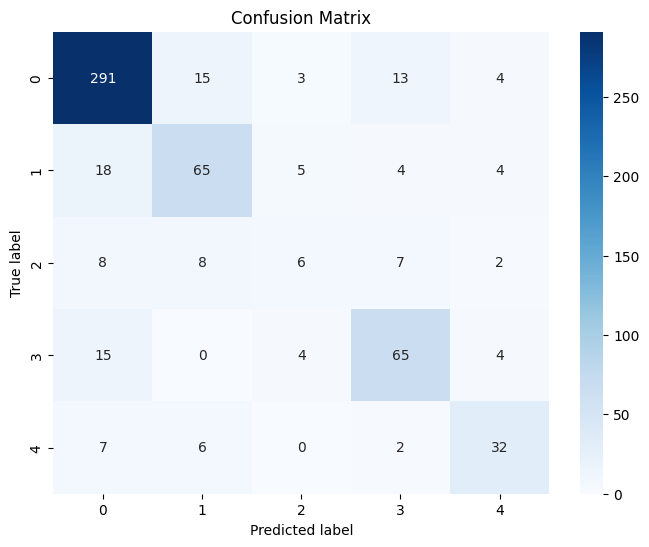

In [200]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

clas_report = classification_report(all_targets, all_preds)
print(clas_report)
conf_matrix = confusion_matrix(all_targets, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

In [201]:
all_test_preds = []

# Test loop
model.eval()
with torch.no_grad():
    for x, x_len in test_loader:
        x = x.to(device).unsqueeze(2)
        hidden, state = model.init_hidden(x.size(0))
        hidden, state = hidden.to(device), state.to(device)
        logits, _ = model(x, (hidden, state), x_len)
        preds = torch.argmax(logits, 1)
        all_test_preds.append(preds.cpu())

all_test_preds = torch.cat(all_test_preds)

In [202]:
import pandas as pd


pd.DataFrame(all_test_preds).to_csv("pred78.csv", header=False, index=False)